In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import tensorflow as tf
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.autograd.variable import Variable

import math
import matplotlib.pyplot as plt
import numpy as np
import copy
from torchvision.utils import make_grid

from transformers import enable_full_determinism

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
torch.manual_seed(1)


In [33]:
DATASET_SCALE = 0.1 # 10% of initial dataset for train, val and test
DATASET_SPLIT = [0.8, 0.2]

# Note to self: moved from /files/ to ./data for lab consistency (see lab 0)

transform = transforms.Compose([
            transforms.ToTensor(),
            ])
    
temp_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

percentage_split = 0.8
def loader(trainlenth, batch_size):
    train_dataset, val_dataset, _ = torch.utils.data.random_split(temp_set, [int(trainlenth*percentage_split), int(trainlenth-(trainlenth*(percentage_split))), len(temp_set)-trainlenth])
    

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader
#train_dataset, val_dataset = random_split(temp_set, DATASET_SPLIT)





In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(1e-2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Tanh()
                    )

    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 256),
                    nn.LeakyReLU(1e-2),
                    #nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.LeakyReLU(1e-2),
                    nn.Sigmoid()
                    )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        return x

In [21]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, torch.ones(n, 1).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, (torch.zeros(n, 1)).to(device))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, torch.ones(n,1).to(device))
    
    error.backward()
    optimizer.step()
    
    return error

In [45]:

def training(training_lenth, batch_size,criterion, generator, discriminator):
    min_loss = 10
    
    epoch_validation_loss = 0
    train_loader, val_loader, _ = loader(training_lenth, batch_size) 
    
    gen_optim = optim.Adam(generator.parameters(), lr=1e-4)
    dis_optim = optim.Adam(discriminator.parameters(), lr=1e-4)
    
    generator.train()
    discriminator.train()
    
    validation_loss = []
    g_losses = []
    d_losses = []
    g_v_losses = []
    d_v_losses = []
    images = []
    
    for epoch in range(num_epochs):
        gen_error = 0.0
        dis_error = 0.0
        for i, data in enumerate(train_loader):
            imgs, _ = data
            n = len(imgs)
            for j in range(k):
                fake_data = generator(Variable(torch.randn(n, 128)).to(device).detach())
                real_data = imgs.to(device)
                dis_error += (train_discriminator(dis_optim, real_data, fake_data)).cpu().detach().numpy().sum()
            fake_data = generator(torch.randn(n, 128).to(device))
            gen_error += (train_generator(gen_optim, fake_data)).cpu().detach().numpy().sum()
        
    
        gen_v_error = 0.0
        dis_v_error = 0.0
    
        for i, data in enumerate(val_loader):
            imgs, _ = data
            n = len(imgs)
            for j in range(k):
                fake_data = generator(Variable(torch.randn(n, 128)).to(device).detach())
                real_data = imgs.to(device)
                dis_v_error += (train_discriminator(dis_optim, real_data, fake_data)).cpu().detach().numpy().sum()
            fake_data = generator(torch.randn(n, 128).to(device))
            
            gen_v_error += (train_generator(gen_optim, fake_data)).cpu().detach().numpy().sum()
             
    
        g_losses.append(gen_error/i)
        d_losses.append(dis_error/i)
        
        d_v_losses.append(dis_v_error/i)
        g_v_losses.append(gen_v_error/i)
        
        print(epoch)
        #print('Training:   Epoch {}: generator_loss: {:.8f} discriminator_loss: {:.8f}\r'.format(epoch, gen_error/i, dis_error/i)) 
        #print('Validation: Epoch {}: generator_loss: {:.8f} discriminator_loss: {:.8f}\r'.format(epoch, gen_v_error/i, dis_error/i))
        validation_loss.append(epoch_validation_loss/len(val_loader))
    
        if ((math.sqrt(gen_v_error/i) + math.sqrt(dis_v_error/i)) < min_loss):
            torch.save(generator, 'best_generator_acc.pt')
            torch.save(discriminator, 'best_discriminator_acc.pt')
            min_loss = math.sqrt(gen_v_error/i)+math.sqrt(dis_v_error/i)
        
    return g_losses, d_losses, g_v_losses, d_v_losses, validation_loss


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

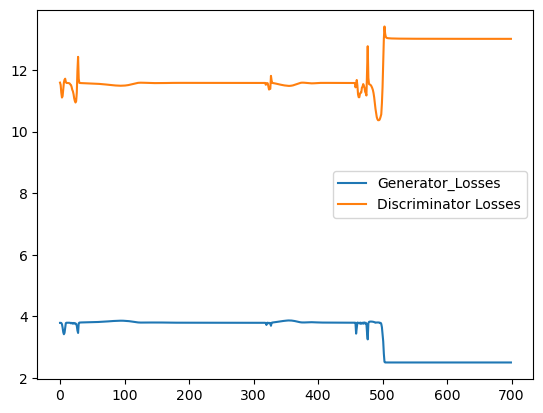

In [46]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)


num_epochs = 700

if 1==0:
    criterion = nn.BCELoss()
else:
    criterion = nn.BCEWithLogitsLoss()

g_losses, d_losses, g_v_losses, d_v_losses, validation_loss = training(1000, 100, criterion, generator, discriminator)

plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')


In [94]:
generator_state = torch.load('best_generator_acc.pt')
discriminator_state = torch.load('best_discriminator_acc.pt')


print(f'Model states contains this data: {model.keys()}')

gan_type = model["gan_type"]  # 
print(f'Using {gan_type} GAN!')

generator = Generator().to(device)
generator.load_state_dict(generator_state["state_dict"], strict=True)
generator.eval() 

discriminator = Discriminator().to(device)
discriminator.load_state_dict(discriminator_state["state_dict"], strict=True)
discriminator.eval() 
    
generated_imgs_path = os.path.join(os.getcwd()+"images/", 'generated_imagery')  
os.makedirs(generated_imgs_path, exist_ok=True)

#
# This is where the magic happens!
#

print('Generating new MNIST-like images!')
generated_img = generate_from_random_latent_vector(generator)
save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=True)

FileNotFoundError: [Errno 2] No such file or directory: 'best_generator_acc.pt'